In [1]:
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time

# Ideas: 

1)Implement NDCG

2)Plot Precision, NDCG vs K

3)For test_set<k, implement a popularity model and fill with most popular songs

In [3]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
user_songs_lcount_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

user_songs_df = pandas.read_csv (user_songs_lcount_file,header=None, sep='\t')
user_songs_df.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
songs_metadata_df =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
df_merge = pandas.merge(user_songs_df, songs_metadata_df.drop_duplicates(['song_id']), on="song_id", how="left") 

In [4]:
import numpy as np
import math
df_merge['listen_count'] =df_merge['listen_count'][df_merge['listen_count']!=0].apply(lambda x: 1+np.log10(x))

In [5]:
df_merge.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.00000,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,1.30103,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.00000,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.00000,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.00000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [6]:
songs_metadata_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [7]:
train_data, test_data = train_test_split(df_merge, test_size = 0.20, random_state=0)
(train_data.head(5))

,user_id,song_id,listen_count,title,release,artist_name,year
608812,7b8fbe766a49e5d7618452149dfab920621fc4fb,SOJJYDE12AF729FC16,1.00000,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
623729,d24956cd68ff84b6d0271286ae6866ee1c89ff77,SOPQGWI12A8C135DDB,1.30103,Royal Gregory,LP,Holy Fuck,2007
583106,da7b91b6cab1ca11227ee7720c4d2e03e8c31579,SOCOIIG12A58A7D151,1.00000,Mr Sandman,Original Hits - 50s,The Chordettes,1993
435735,5f633da6ad4845350949c3c76ce6c4ef6f167476,SOQQTBB12AB0182F1D,1.30103,A Days Work (feat. P.O.S),Rádio do Canibal,BK-One,0
1361953,01ad0fabd01af750700a1e80bb0055abcb3edd28,SOVYNVS12AC3DF64AB,1.30103,Rockin' Rollin' Stone,100 Greatest Rockabilly Hits,Andy Starr,2000


In [8]:
test_data.head()

,user_id,song_id,listen_count,title,release,artist_name,year
1319600,bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0,SORVKCB12AB0188D90,1.301030,Big Calm,Big Calm,Morcheeba,1998
1697773,da5d0afc724e7d63b9e90552a4d148fcce94e97e,SOGJMJH12A6702154D,1.000000,Closer,The Downward Spiral,Nine Inch Nails,1994
742836,4e23d4c1111c206e2dc0984c9d1b2e3bff510482,SOAXGDH12A8C13F8A1,1.000000,Dog Days Are Over (Radio Edit),Now That's What I Call Music! 75,Florence + The Machine,0
114563,2109f4ce04660f2d92d7bc36b0c221d171172d6b,SOMWASN12A6D4F72B3,1.477121,Bricks,The Sufferer & The Witness,Rise Against,2006
236686,74e3254cb58a35de657126e9e2f61b474857ff0f,SOYGHUM12AB018139C,1.602060,Bad Company,War Is The Answer,Five Finger Death Punch,2009


In [10]:
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 10))

In [11]:
train_dataSVD = Dataset.load_from_df(train_data[['user_id', 'song_id', 'listen_count']], reader)
test_dataSVD = Dataset.load_from_df(test_data[['user_id', 'song_id', 'listen_count']], reader)

In [12]:
trainset = train_dataSVD.build_full_trainset()

In [13]:
algo1= SVD()
algo2 = SVDpp()

In [14]:
algo1.fit(trainset)

In [15]:
algo2.fit(trainset)

In [20]:
ground_truth = list(test_data['listen_count'])

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def find_RMS(y_predicted,y_actual):
    return sqrt(mean_squared_error(y_actual, y_predicted))

def find_MAE(y_predicted, y_actual):
    return mean_absolute_error(y_actual,y_predicted)


In [22]:
def predict(algo, name):
    prediction= [algo.predict(row['user_id'], row['song_id'], verbose=False).est for index,row in test_data.iterrows()]
    print("RMS Error for", name, " is ",find_RMS(prediction,ground_truth))
    print("MAE Error for", name, " is ",find_MAE(prediction,ground_truth))
    return prediction

In [23]:
predictSVD= predict(algo1, 'SVD')

RMS Error for SVD  is  0.32259055548269383
MAE Error for SVD  is  0.24682773235930977


In [27]:
import pickle
pickle.dump( predictSVD, open( "svd.p", "wb" ) )

In [28]:
predictSVDPP=predict(algo2, 'SVDPP')

RMS Error for SVDPP  is  0.31725306402477366
MAE Error for SVDPP  is  0.24182494124705559


In [29]:
pickle.dump( predictSVDPP, open( "svdpp.p", "wb" ))

In [30]:
def findUSerCounts(df):
    user_counts={}
    for index,row in df.iterrows():
        ui = row['user_id']
        song= row['song_id']
        count= row ['listen_count']
        if ui not in user_counts:
            user_counts[ui]={}
        user_counts[ui][song]= count
    return user_counts

In [31]:
predict_data_SVD = test_data.copy()
predict_data_SVD['listen_count']= predictSVD

In [32]:
predict_data_SVDPP = test_data.copy()
predict_data_SVDPP['listen_count']= predictSVDPP

In [33]:
predict_user_dict_SVD= findUSerCounts(predict_data_SVD)

In [34]:
predict_user_dict_SVDPP= findUSerCounts(predict_data_SVDPP)

In [40]:
test_user_dict=findUSerCounts(test_data)

In [41]:
def findTopKSongUser(user, df,k ):
    user_dict= df[user]
    top= sorted(user_dict.items(), key=lambda x: x[1], reverse=True)
    topk_songs= [el[0] for el in top[:k]]
    return topk_songs

In [42]:
k=10

In [43]:
def print_names(songs_list):
    titles=[]
    for song in songs_list:
        new_df=songs_metadata_df.loc[songs_metadata_df.song_id==song].values
        title=new_df[0,1]+' - '+new_df[0,2]
        print(title)
        titles.append(title)
    return titles

In [44]:
topk_pred_user_SVD= findTopKSongUser ('bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0',predict_user_dict_SVD,k )
titles=print_names(topk_pred_user_SVD)

Old Man Time (Album Version) - In Between Now And Then
Who's Real - The Last Kiss
The Way I Feel (Not Our Master) - 12 Stones
Con Mis Manos - Pafuera Telarañas
Me & Mr Jones - Me & Mr Jones
Constellations - In Between Dreams
If I Could - In Between Dreams
Do You Remember - In Between Dreams
Beautiful Morning - Da Capo
Sandman - Here & Now


In [45]:

topk_test_user= findTopKSongUser ('bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0',test_user_dict,k )
titles=print_names(topk_test_user)

Part Of The Process - Parts Of The Process
Alala (Album) - Cansei De Ser Sexy
Sandman - Here & Now
Con Mis Manos - Pafuera Telarañas
Big Calm - Big Calm
Fear And Love - Big Calm
Do You Remember - In Between Dreams
Who's Real - The Last Kiss
Constellations - In Between Dreams
If I Could - In Between Dreams


In [46]:
def findTopKSongs(user_dic,k):
    user_topKsongs= {}
    for user in user_dic.keys():
        user_topKsongs[user]= findTopKSongUser(user,user_dic,k)
    return user_topKsongs
    

In [47]:
topksongs_pred_SVD= findTopKSongs(predict_user_dict_SVD,k)


In [49]:
topksongs_pred_SVDPP= findTopKSongs(predict_user_dict_SVDPP,k)


In [50]:
topksongs_test= findTopKSongs(test_user_dict,k)


In [77]:
def findPrecision_user(pred_user,test_user,k):
    tp=len(list(set(pred_user[:k]).intersection(test_user[:k])))
    precision= tp/min(k,len(test_user))
    #recall= tp/len(test)
    #print('precision is :',precision )
    #print('recall is :', recall)
    return precision
        

In [78]:
precision_user= findPrecision_user(topk_pred_user_SVD,topk_test_user,k)

In [79]:
print(precision_user)

0.6


In [80]:
def order_songs(user, df ):
    sort_list= (sorted(df[user].items(), key=lambda x: x[1], reverse=True))
    return sort_list, dict(sort_list)

def find_test_relscores(dic):
    rel_scores_list={}
    rel_scores_dic={}
    for user in dic.keys():
        rel_scores_list[user],rel_scores_dic[user]=order_songs(user,dic)   
    return rel_scores_list,rel_scores_dic
    

In [81]:
test_rel_scores_list,test_rel_scores_dict = find_test_relscores(test_user_dict)


In [88]:
def find_NDCG_user(klist_pred,klist_test,rankdict):
    
    #dcgk
    dcg=sum(sum( ((rankdict[el] if el in rankdict else 0 )/ np.log2(np.arange(2, len(klist_pred) + 2))) for el in klist_pred))
    #print('dcg :', dcg)
    idcg= sum(sum( (np.power(2, rankdict[el] if el in rankdict else 0) - 1) / np.log2(np.arange(2, len(klist_test) + 2)) for el in klist_test))
    #print('idcg :', idcg)
    return dcg/idcg

In [83]:
find_NDCG_user(topk_pred_user_SVD,topk_test_user,test_rel_scores_dict['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'])

0.7518235747603215

In [97]:
def evaluate(pred, test,k,scores_dict): 
    #print('k is ',k)
    avg_precision= np.mean(list(findPrecision_user(pred[user],test[user],k) for user in test.keys()))
    #print('Average precision is:',avg_precision )
    avg_ndcg= np.mean(list(find_NDCG_user(pred[user][:k],test[user][:k],scores_dict[user]) for user in test.keys()))
    #print('Average NDCG is:',avg_ndcg )
    return avg_precision,avg_ndcg

In [90]:
precision_SVD,ndcg_SVD= evaluate(topksongs_pred_SVD,topksongs_test,5,test_rel_scores_dict)
print('Average precision is:',precision_SVD )
print('Average NDCG is:',ndcg_SVD )

Average precision is: 0.8551436488260171
Average NDCG is: 0.8384448190239389


In [91]:
precision_SVDPP,ndcg_SVDPP= evaluate(topksongs_pred_SVDPP,topksongs_test,5,test_rel_scores_dict)
print('Average precision is:',precision_SVDPP )
print('Average NDCG is:',ndcg_SVDPP )

Average precision is: 0.8575061980457926
Average NDCG is: 0.8395972319455253


In [92]:
def eval_model(pred_user_dict,act_user_dict,rank_dic,krange):
    prec_list=[]
    ndcg_list=[]
    for kval in krange:
        topksongs_pr= findTopKSongs(pred_user_dict,kval)
        topksongs_ac= findTopKSongs(act_user_dict,kval)
        precision,ndcg = evaluate(topksongs_pr,topksongs_ac,kval,rank_dic)
        prec_list.append(precision)
        ndcg_list.append(ndcg)
    return prec_list,ndcg_list


In [93]:
krange= list(range(2,15))
precision_vals_SVD, ndcg_vals_SVD= eval_model(predict_user_dict_SVD,test_user_dict,test_rel_scores_dict,krange)

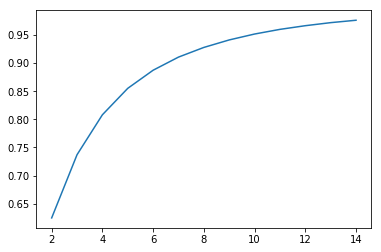

In [95]:
import matplotlib.pyplot as plt
plt.plot(np.array(krange),np.array(precision_vals_SVD))
plt.show()

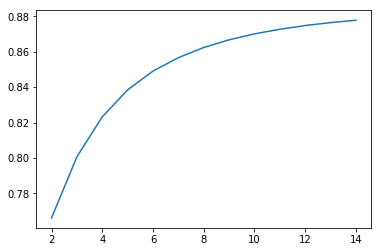

In [96]:
plt.plot(np.array(krange),np.array(ndcg_vals_SVD))
plt.show()

In [ ]:
precision_vals_SVDPP, ndcg_vals_SVDPP= eval_model(predict_user_dict_SVDPP,test_user_dict,test_rel_scores_dict,krange)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(krange),np.array(precision_vals_SVDPP))
plt.show()

In [ ]:
plt.plot(np.array(krange),np.array(ndcg_vals_SVDPP))
plt.show()

## Popularity Based Model

In [112]:
song_tot_count ={}
for song in list(train_data['song_id'].unique()):
    song_tot_count[song]= np.sum(train_data.loc[train_data.song_id==song]['listen_count'])


KeyboardInterrupt: 

In [68]:
def find_topK_pop_songs_user(k):
    topk_pop_songs=[]
    top=(sorted(song_tot_count.items(), key=lambda x: x[1], reverse=True))[:k]
    topk_pop_songs= [el[0] for el in top[:k]]
    return topk_pop_songs

In [69]:
topk_pop_songs_user= find_topK_pop_songs_user(k)
print_names(topk_pop_songs_user)

['SOFRQTD12A81C233C0',
 'SOAUWYT12A81C206F1',
 'SOBONKR12A58A7A7E0',
 'SOAXGDH12A8C13F8A1',
 'SOSXLTC12AF72A7F54',
 'SOEGIYH12A6D4FC0E3',
 'SONYKOW12AB01849C9',
 'SODJWHY12A8C142CCE',
 'SOLFXKT12AB017E3E0',
 'SOFLJQZ12A6D4FADA6']

In [47]:
test_users= list(test_user_dict.keys())
def find_topk_pop_songs(k):
    topk_pop_songs={}
    for user in test_users:
        topk_pop_songs[user]= topk_pop_songs_user
    return topk_pop_songs
    

In [72]:
topk_pop_songs_pred=find_topk_pop_songs(k)
topk_pop_songs_test=topksongs_test

In [106]:
find_NDCG_user(topk_pop_songs_pred['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'],topk_pop_songs_test['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'],test_rel_scores_dict['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'])

0.0

In [105]:
evaluateModel(topk_pop_songs_pred,topk_pop_songs_test,k,test_rel_scores_dict)

k is  10
Average precision is: 0.037090026181101
Average NDCG is: 0.1660450733014201


(0.037090026181101, 0.1660450733014201)

In [116]:
print_names(topk_pop_songs_pred['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'])

['SOFRQTD12A81C233C0',
 'SOAUWYT12A81C206F1',
 'SOBONKR12A58A7A7E0',
 'SOAXGDH12A8C13F8A1',
 'SOSXLTC12AF72A7F54',
 'SOEGIYH12A6D4FC0E3',
 'SONYKOW12AB01849C9',
 'SODJWHY12A8C142CCE',
 'SOLFXKT12AB017E3E0',
 'SOFLJQZ12A6D4FADA6']

In [117]:
print_names(topk_pop_songs_test['bba304c2ed4ef5ae8f15fd4fca4a694cf6c0e8a0'])

['SOOCEKO12A67ADF6D9',
 'SOWRGDS12A6D4F94EE',
 'SOUGSKL12A8C13F7BB',
 'SOJWIJT12A8C136100',
 'SORVKCB12AB0188D90',
 'SODLCIU12A8AE45F1D',
 'SOKUTUM12A6701D9CD',
 'SOXHIDK12A58A7CFB3',
 'SOBYHAJ12A6701BF1D',
 'SOKLVUI12A6701BF1B']

In [110]:
def popularity_model(act_user_dict,rank_dic,krange):
    prec_list=[]
    ndcg_list=[]
    for kval in krange:
        topksongs_pr= topk_pop_songs_pred
        topksongs_ac= findTopKSongs(act_user_dict,kval)
        precision,ndcg = evaluateModel(topksongs_pr,topksongs_ac,kval,rank_dic)
        prec_list.append(precision)
        ndcg_list.append(ndcg)
    return prec_list,ndcg_list


In [111]:
krange= list(range(2,15))
precision_vals, ndcg_vals= popularity_model(test_user_dict,test_rel_scores_dict,krange)

k is  2
Average precision is: 0.04400612512760683
Average NDCG is: 0.3911652602624927
k is  3
Average precision is: 0.04127169316027417
Average NDCG is: 0.25818221703863786
k is  4
Average precision is: 0.03967235428515872
Average NDCG is: 0.2112694976359811
k is  5
Average precision is: 0.038775460599873614
Average NDCG is: 0.1904495443472979
k is  6
Average precision is: 0.038187740022361576
Average NDCG is: 0.17980728424285078
k is  7
Average precision is: 0.03775613380834324
Average NDCG is: 0.17375836571188494
k is  8
Average precision is: 0.03748815947554463
Average NDCG is: 0.17005419360683713
k is  9
Average precision is: 0.037257251887192096
Average NDCG is: 0.16765143471613053
k is  10
Average precision is: 0.037090026181101
Average NDCG is: 0.1660450733014201
k is  11
Average precision is: 0.03694153823911736
Average NDCG is: 0.16492709264119063
k is  12
Average precision is: 0.036832050478324364
Average NDCG is: 0.16412783986726123
k is  13
Average precision is: 0.036752588

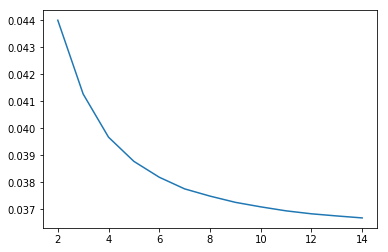

In [113]:
import matplotlib.pyplot as plt
plt.plot(np.array(krange),np.array(precision_vals))
plt.show()

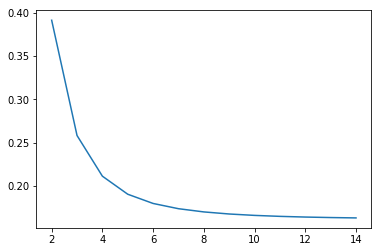

In [115]:
plt.plot(np.array(krange),np.array(ndcg_vals))
plt.show()

# Hybrid Model

In [111]:
def ensemble(preds,k):
    pred_ens=np.mean(np.array(preds),axis=0)
    print("RMS Error for Ensemble approach is ",find_RMS(pred_ens,ground_truth))
    print("MAE Error for Ensemble approach is ", find_MAE(pred_ens,ground_truth))
    predict_data_ens = test_data.copy()
    predict_data_ens['listen_count']= pred_ens
    predict_user_dict_ens= findUSerCounts(predict_data_ens)
    topksongs_pred_ens= findTopKSongs(predict_user_dict_ens,k)
    return predict_user_dict_ens,topksongs_pred_ens
    
    

In [112]:
preds=[]
preds.append(predictSVD)
preds.append(predictSVDPP)

In [113]:
predict_user_dict_ens,topksongs_pred_ens= ensemble(preds,k)

RMS Error for Ensemble approach is  0.3180384075411488
MAE Error for Ensemble approach is  0.243710744080551


In [115]:
precision_ens,ndcg_ens= evaluate(topksongs_pred_ens,topksongs_test,5,test_rel_scores_dict)
print('Average precision is:',precision_ens )
print('Average NDCG is:',ndcg_ens )

Average precision is: 0.8566982645471781
Average NDCG is: 0.8393463054111678


In [116]:
precision_vals_ens, ndcg_vals_ens= eval_model(predict_user_dict_ens,test_user_dict,test_rel_scores_dict,krange)

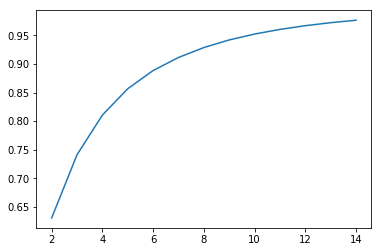

In [117]:
plt.plot(np.array(krange),np.array(precision_vals_ens))
plt.show()

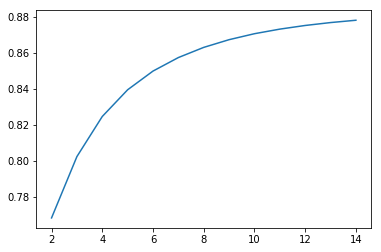

In [118]:
plt.plot(np.array(krange),np.array(ndcg_vals_ens))
plt.show()